<a href="https://colab.research.google.com/github/yuanfongsu/yuanfongsu.github.io/blob/main/RS_1142_Course_01_setup_map_aoi_taiwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01_setup_map_aoi_taiwan.ipynb

## Objective
Set up Colab + Earth Engine, define Taiwan as the Area of Interest (AOI), and display a Sentinel-2 RGB image.

## Datasets used
- `FAO/GAUL/2015/level0` or `USDOS/LSIB_SIMPLE/2017` (Taiwan boundary)
- `COPERNICUS/S2_SR_HARMONIZED` (Sentinel-2 surface reflectance)

## Steps (what you will do)
1. Install packages and authenticate EE.
2. Build Taiwan AOI and open an interactive map.
3. Load and display one Sentinel‑2 RGB image.


### 1) Install + authenticate
This connects your Colab session to Google Earth Engine.


In [1]:
# (Colab) Install dependencies
!pip -q install geemap

import ee, geemap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


In [2]:
# Authenticate Earth Engine (first time only)
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-suyuanfong") # you need to change to your project name


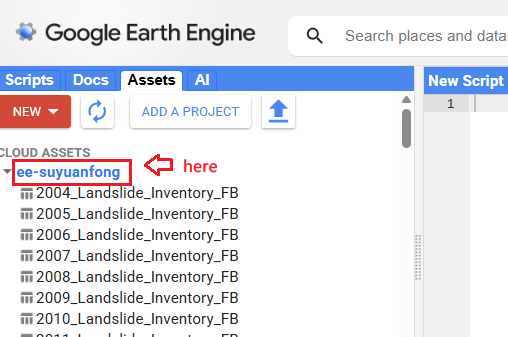

### 2) Define Taiwan AOI and open an interactive map
We create a Taiwan boundary geometry and visualize it on an interactive map.


In [3]:
# Taiwan AOI (tries GAUL first; falls back to LSIB if needed)
gaul0 = ee.FeatureCollection("FAO/GAUL/2015/level0")
tw_gaul = gaul0.filter(ee.Filter.eq("ADM0_NAME", "Taiwan")).first()

lsib = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
tw_lsib = lsib.filter(ee.Filter.eq("country_na", "Taiwan")).first()

tw_feat = ee.Feature(ee.Algorithms.If(tw_gaul, tw_gaul, tw_lsib))
aoi = tw_feat.geometry()

Map = geemap.Map()
Map.centerObject(aoi, 7)
Map.addLayer(aoi, {}, "Taiwan AOI")
Map


Map(center=[23.742596884740607, 120.96229620901137], controls=(WidgetControl(options=['position', 'transparent…

### 3) Load a single Sentinel-2 image and visualize true color (RGB)
We fetch one low-cloud Sentinel-2 image and display it as a quick sanity check.


In [6]:
s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
      .filterBounds(aoi)
      .filterDate("2024-04-01", "2024-06-01")
      .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", 10)))

img = ee.Image(s2.first()).clip(aoi)
print(img.getInfo())
rgb_vis = {"min": 0, "max": 3000, "bands": ["B4", "B3", "B2"]}
Map.addLayer(img, rgb_vis, "S2 SR RGB (one image)")
Map


{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1232, 1830], 'origin': [598, 0], 'crs': 'EPSG:32650', 'crs_transform': [60, 0, 699960, 0, -60, 2600040]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7391, 10980], 'origin': [3589, 0], 'crs': 'EPSG:32650', 'crs_transform': [10, 0, 699960, 0, -10, 2600040]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7391, 10980], 'origin': [3589, 0], 'crs': 'EPSG:32650', 'crs_transform': [10, 0, 699960, 0, -10, 2600040]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7391, 10980], 'origin': [3589, 0], 'crs': 'EPSG:32650', 'crs_transform': [10, 0, 699960, 0, -10, 2600040]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [36

Map(bottom=1817319.0, center=[23.367865257430804, 119.51378345489503], controls=(WidgetControl(options=['posit…

In [8]:
# 20 km central Taiwan region
center_pt = aoi.centroid(1)
center_region = center_pt.buffer(20000).bounds()   # 20 km buffer

# Base Sentinel-2 collection
s2_base = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
           .filterDate("2024-04-01", "2024-06-01")
           .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", 10)))

# Get the tile(s) that cover the 20 km region
tiles = ee.List(s2_base.filterBounds(center_region).aggregate_array("MGRS_TILE")).distinct()
print("Center tiles (20 km):", tiles.getInfo())

# Filter collection to those tiles + that region
s2_center_tiles = (s2_base
                   .filter(ee.Filter.inList("MGRS_TILE", tiles))
                   .filterBounds(center_region))

print("Images in center tiles:", s2_center_tiles.size().getInfo())

# Visualize region
Map = geemap.Map()
Map.centerObject(center_region, 9)
Map.addLayer(center_region, {}, "Center region (20 km)")
Map


Center tiles (20 km): ['50QRM', '51QTG']
Images in center tiles: 2


Map(center=[23.74258946283556, 120.96263637604794], controls=(WidgetControl(options=['position', 'transparent_…

In [9]:
tile_one = ee.String(s2_base.filterBounds(center_region).first().get("MGRS_TILE"))
s2_one_tile = (s2_base
               .filter(ee.Filter.eq("MGRS_TILE", tile_one))
               .filterBounds(center_region))
print("Centroid tile:", tile_one.getInfo())
print("Images:", s2_one_tile.size().getInfo())


Centroid tile: 50QRM
Images: 1


In [11]:
# Make a composite from the one-tile collection
img_one = s2_one_tile.median().clip(center_region)

# Visualization (true color)
rgb_vis = {"min": 0, "max": 3000, "bands": ["B4", "B3", "B2"]}

Map = geemap.Map()
Map.centerObject(center_region, 12)
Map.addLayer(center_region, {}, "Center region (20 km)")
Map.addLayer(img_one, rgb_vis, "Sentinel-2 (one tile) RGB")
Map


Map(center=[23.74258946283556, 120.96263637604794], controls=(WidgetControl(options=['position', 'transparent_…

Pratice:
1. Go to the area of interest (AOI) and find a cloud free Sentinel-2 image
2. rgb_vis = {"min": 0, "max": 3000, "bands": ["B4", "B3", "B2"]}, you can change this setting to see what happen if you change the min or max or different combination of bands.